In [30]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'C:\Users\luukwouterse\Downloads/CapstoneAI-FiberProbe-main/CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [31]:
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data, save_second_scaler
from models import load_scalers, load_models, LSTMModel, GRUModel

In [32]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2412_Capstone AI\Capstone data\Data'
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data
from models import load_scalers, load_models, LSTMModel, GRUModel

In [ ]:
df = process_folder(path_to_data, path_to_output, plot=False, labels=True)
feature_scaler, target_scaler, X_train, y_train, X_val, y_val, X_test, y_test = save_second_scaler(df)

Binlog data extracted
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 60, 'bin_file': '2024-11-12T145426.bin'}


In [27]:
print(X_train)
print(y_train)
print(y_val)

[[-1.01694889 -0.53118426 -0.68171774 ...  0.78896433  0.85746925
   1.08142309]
 [ 0.945617    0.56960979  1.72413608 ...  0.22196841 -0.49849697
  -0.36028201]
 [ 0.89456642 -0.53118426  0.3976509  ... -0.41459003 -0.38295395
   0.31563883]
 ...
 [ 0.1118083  -0.18066776 -0.23860831 ... -0.00509348 -0.75083158
  -0.22483763]
 [ 1.14130584  1.82393657  2.61035496 ...  0.69840258  0.37404989
   0.36122233]
 [ 0.55140057 -0.4819369   0.94017558 ... -0.59571481 -1.0031649
  -0.69759128]]
[-0.84383335  0.26776175  0.73419008 -0.54530565 -1.49432351 -0.08341669
 -1.36141358 -0.50438875 -0.94116624 -0.41358821  0.63323361  0.67041821
 -0.82010873 -0.35346299  0.35294903 -0.29472791 -0.47172374 -0.06606959
  1.68612328 -0.14203647  1.14075343 -1.1505339   0.29859849 -0.77566048
 -0.28325102 -0.19014785  1.07043604 -1.45096563  2.70326461  0.06383277
 -0.09672185  3.16178034  0.1481965  -0.53099248 -0.18770687 -0.36622461
 -0.4972404  -0.56614458 -0.51460727 -1.19114774 -0.74196769  1.1075975

In [ ]:
X_train_tensor = torch.tensor(X_train[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val[..., np.newaxis], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Initialize model
model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
model.to('cpu')  # or 'cuda' if using GPU

# Training setup
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
epochs = 30

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

In [23]:
# Predict on validation set
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.030 cm/s
MAE: 0.138 cm/s
R² Score: -1.657


In [24]:
print(np.var(y_true))


0.011464879


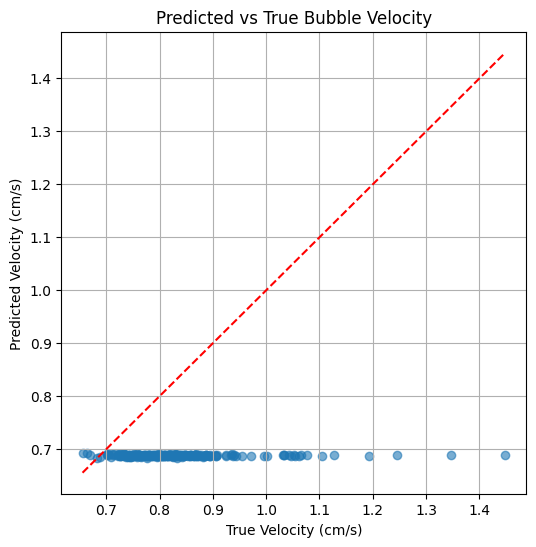

In [25]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel("True Velocity (cm/s)")
plt.ylabel("Predicted Velocity (cm/s)")
plt.title("Predicted vs True Bubble Velocity")
plt.grid(True)
plt.show()

In [26]:
print("Prediction range:", y_pred.min(), y_pred.max())


Prediction range: 0.68257177 0.6931912
